In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.patches import Patch

---

# PLOT 3: HORIZONTAL BAR PLOT

---

For this representation we will be using Dataset 3. We want to know where are the inmigrants with postmandatory studies from and in which districts of Barcelona are they living.

In [12]:
# We create a folder to save the different plots
os.makedirs('outputs/results_plot4', exist_ok=True)

# We read the data
df=pd.read_csv('generated_data/education_continents_1997-2025.csv')

# We delete the 'no consta' because they are negligible
df=df[~df["Titulación académica"].str.strip().str.lower().eq("no consta")]
df=df[~df["Continente"].str.strip().str.lower().eq("no consta")]

# Let's group America and Oceania
df["group_continent"]=df["Continente"].replace({
    "América": "América-Oceanía",
    "Oceanía": "América-Oceanía"
})

# We select the postmandatory levels using keywords
keywords=["Bachillerato", "COU", "FPII", "CFGM", "grado medio", "universitarios", "CFGS"]
mask=df["Titulación académica"].str.contains("|".join(keywords), case=False, na=False)
df_educated=df[mask].copy()

# We save the new dataset
df_educated.to_csv('generated_data/postcompulsory_continents_1997-2025.csv', index=False, encoding='utf-8')
df_educated

,Territorio,Titulación académica,Poblacion,Continente,Año,group_continent
2,Ciutat Vella,"Bachillerato elemental, graduado escolar, ESO,...",129.0,África,1997.0,África
3,Ciutat Vella,"Bachillerato superior, BUP, COU, FPII, CFGM gr...",197.0,África,1997.0,África
4,Ciutat Vella,"Estudios universitarios, CFGS grado superior",73.0,África,1997.0,África
8,Eixample,"Bachillerato elemental, graduado escolar, ESO,...",126.0,África,1997.0,África
9,Eixample,"Bachillerato superior, BUP, COU, FPII, CFGM gr...",280.0,África,1997.0,África
...,...,...,...,...,...,...
7986,Nou Barris,"Estudios universitarios, CFGS grado superior",11.0,Oceanía,2025.0,América-Oceanía
7987,Sant Andreu,"Estudios universitarios, CFGS grado superior",12.0,Oceanía,2025.0,América-Oceanía
7989,Sant Martí,"Bachillerato elemental, graduado escolar, ESO,...",11.0,Oceanía,2025.0,América-Oceanía
7990,Sant Martí,"Bachillerato superior, BUP, COU, FPII, CFGM gr...",17.0,Oceanía,2025.0,América-Oceanía


In [13]:
# We read the data
df=pd.read_csv('generated_data/postcompulsory_continents_1997-2025.csv')

# We create a plot for each year
years=sorted(df['Año'].unique())

# Viridis palette
viridis_colors=plt.cm.viridis(np.linspace(0, 1, 4))

# Color mapping
color_map={
    "África": viridis_colors[0],
    "Asia": viridis_colors[1],
    "América-Oceanía": viridis_colors[2],
    "Europa": viridis_colors[3]
}

# Legend
legend=[
    Patch(facecolor=viridis_colors[0], label="Africa"),
    Patch(facecolor=viridis_colors[1], label="Asia"),
    Patch(facecolor=viridis_colors[2], label="Americas-Oceania"),
    Patch(facecolor=viridis_colors[3], label="Europe")
]

district_order=[
    "Nou Barris", "Ciutat Vella", "Sant Andreu", "Sants-Montjuïc",
    "Horta-Guinardó", "Sant Martí", "Gràcia", "Eixample",
    "Les Corts", "Sarrià-Sant Gervasi"
]

for year in years:

    df_year=df_educated[df_educated["Año"]==year].copy()
    
    # Pivot table
    pivot_dc=df_year.pivot_table(
        index="Territorio",
        columns="group_continent",
        values="Poblacion",
        aggfunc="sum"
    ).fillna(0)

    # Reorder columns
    order=["África", "Asia", "América-Oceanía", "Europa"]
    pivot_dc=pivot_dc[[c for c in order if c in pivot_dc.columns]]
    
    # Reorder districts
    pivot_dc=pivot_dc.reindex(district_order)
    
    # Percentages
    row_sums=pivot_dc.sum(axis=1).replace(0, np.nan)
    pivot_pct=pivot_dc.div(row_sums, axis=0).fillna(0)*100
    
    fig, ax=plt.subplots(figsize=(10, 6))
    left=np.zeros(len(pivot_pct))
    y=np.arange(len(pivot_pct))
    
    # Plot horizontal bars
    for col in pivot_pct.columns:
        vals=pivot_pct[col].values
        ax.barh(y, vals, left=left, color=color_map[col], label=col)
        left+=vals
    
    ax.set_yticks(y)
    ax.set_yticklabels(pivot_pct.index)
    ax.set_xlabel("Population (%)", fontsize=12, fontweight='bold')
    ax.set_ylabel("Districts (low to high rent)", fontsize=12, fontweight='bold')
    ax.set_xlim(0, 100)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
    ax.xaxis.grid(True, linestyle='--', alpha=0.5)
    ax.legend(handles=legend, title='Continent', bbox_to_anchor=(1.02, 1),title_fontsize=12, loc='upper left', frameon=False)
    
    # Add year annotation
    ax.text(0.99, 1.05, f'{int(year)}', transform=ax.transAxes, fontsize=12,
            fontweight='bold', verticalalignment='top', horizontalalignment='right')
    
    plt.tight_layout()
    fig.savefig(f'outputs/results_plot4/plot4_{year}.png', dpi=300, bbox_inches='tight')
    plt.close()

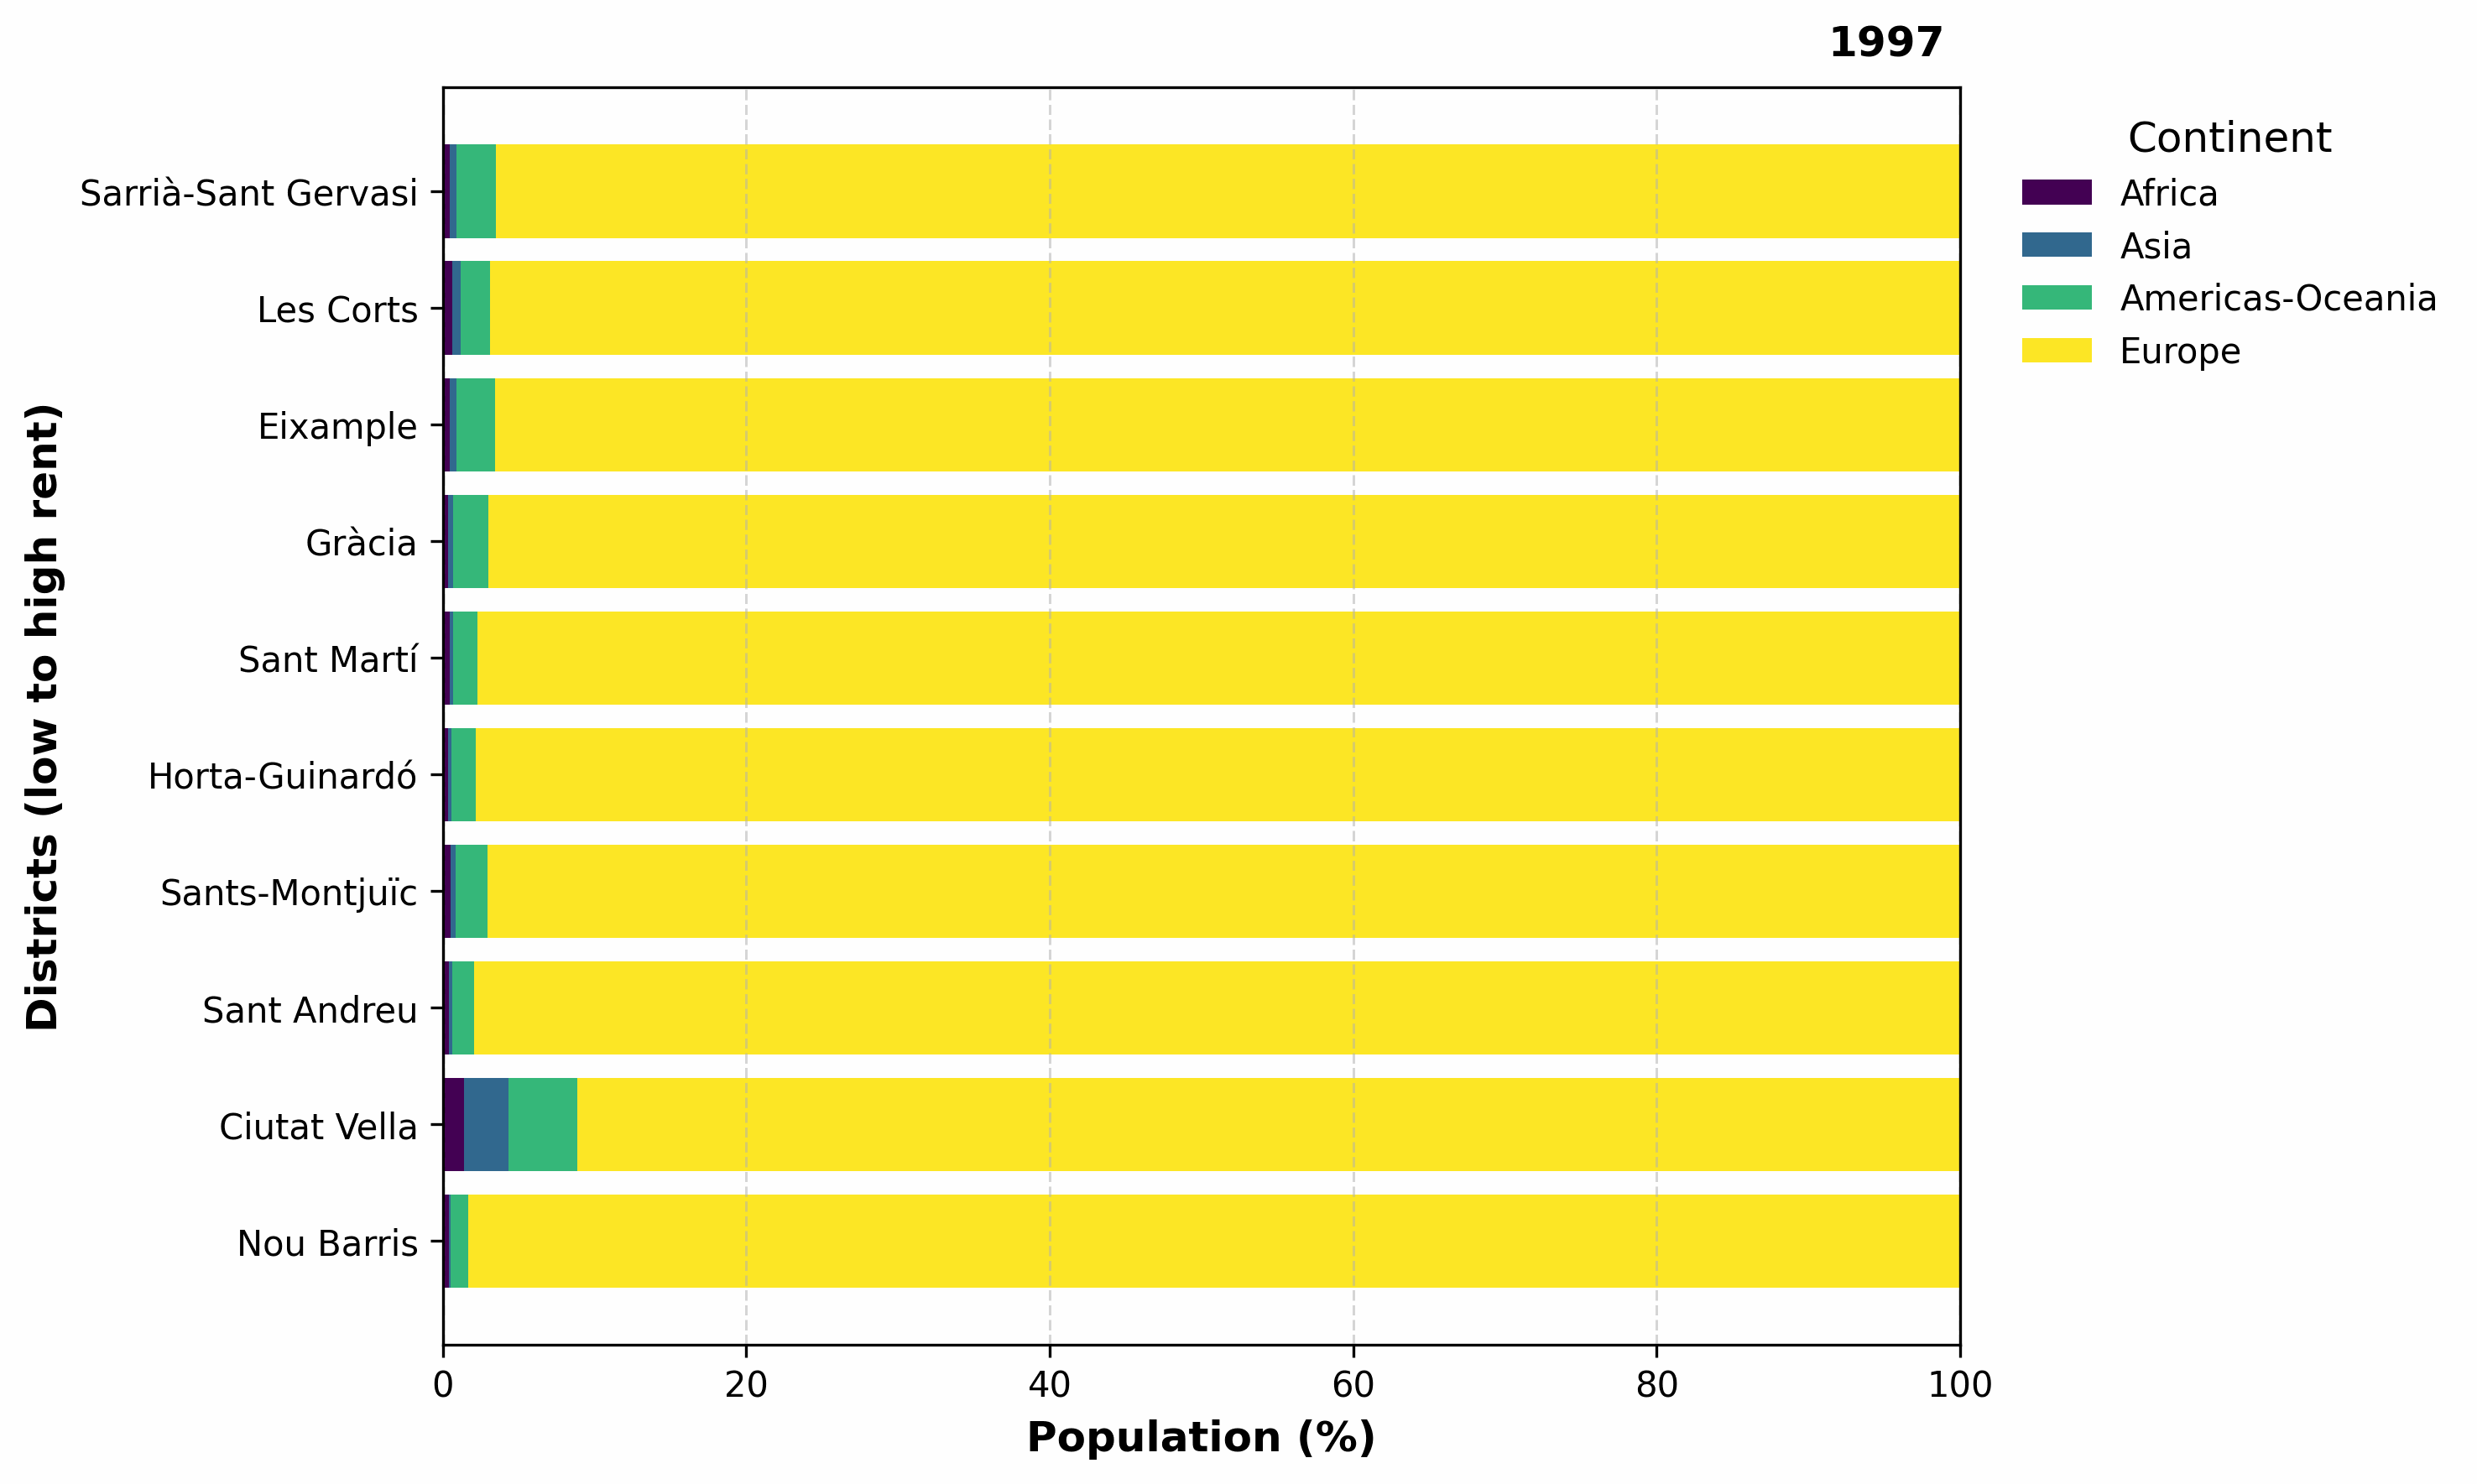

In [14]:
from PIL import Image

# We create a gif over the years
frames_dir="outputs/results_plot4"
files=sorted([f for f in os.listdir(frames_dir) if f.endswith(".png")])
frame_files=[os.path.join(frames_dir, f) for f in files]

frames=[Image.open(f) for f in frame_files]

frames[0].save(
    "outputs/plot4.gif",
    save_all=True,
    append_images=frames[1:],
    duration=500,   
    loop=0
)

from IPython.display import Image, display

display(Image(filename="outputs/plot4.gif"))

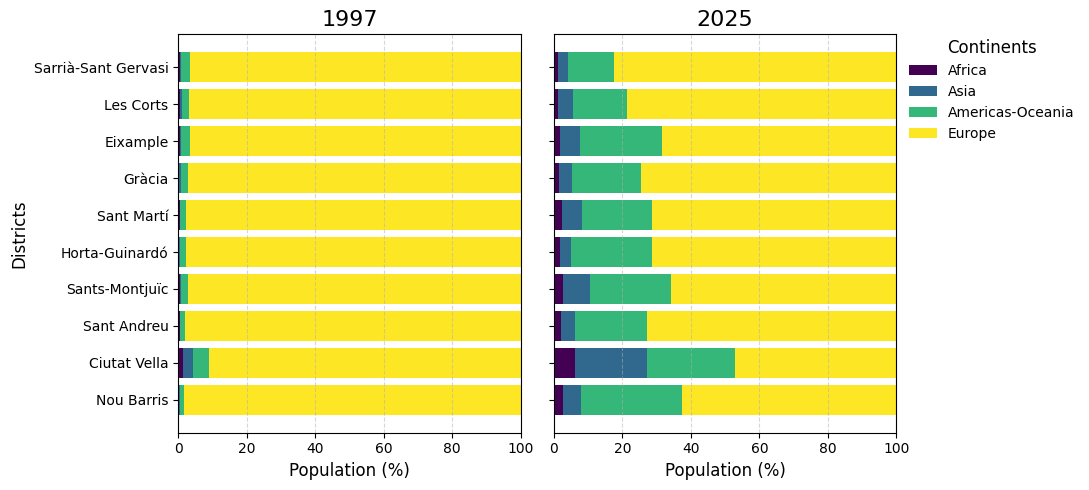

In [15]:
# We delete 'no consta' because they are negligible
df = df[~df["Titulación académica"].str.strip().str.lower().eq("no consta")]
df = df[~df["Continente"].str.strip().str.lower().eq("no consta")]

# Group America and Oceania
df["group_continent"] = df["Continente"].replace({
    "América": "América-Oceanía",
    "Oceanía": "América-Oceanía"
})

# Select postmandatory education levels
keywords = ["Bachillerato", "COU", "FPII", "CFGM", "grado medio", "universitarios", "CFGS"]
mask = df["Titulación académica"].str.contains("|".join(keywords), case=False, na=False)
df_educated = df[mask].copy()

# Only these two years
years = [1997, 2025]

# Viridis palette
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 4))

color_map = {
    "África": viridis_colors[0],
    "Asia": viridis_colors[1],
    "América-Oceanía": viridis_colors[2],
    "Europa": viridis_colors[3]
}

legend = [
    Patch(facecolor=viridis_colors[0], label="Africa"),
    Patch(facecolor=viridis_colors[1], label="Asia"),
    Patch(facecolor=viridis_colors[2], label="Americas-Oceania"),
    Patch(facecolor=viridis_colors[3], label="Europe")
]

district_order = [
    "Nou Barris", "Ciutat Vella", "Sant Andreu", "Sants-Montjuïc",
    "Horta-Guinardó", "Sant Martí", "Gràcia", "Eixample",
    "Les Corts", "Sarrià-Sant Gervasi"
]

# === TWO HORIZONTAL SUBPLOTS (with X axis in both) === #
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), sharey=True)

axs = [ax1, ax2]

for i, year in enumerate(years):

    df_year = df_educated[df_educated["Año"] == year].copy()
    
    pivot_dc = df_year.pivot_table(
        index="Territorio",
        columns="group_continent",
        values="Poblacion",
        aggfunc="sum"
    ).fillna(0)

    order = ["África", "Asia", "América-Oceanía", "Europa"]
    pivot_dc = pivot_dc[[c for c in order if c in pivot_dc.columns]]
    pivot_dc = pivot_dc.reindex(district_order)
    
    row_sums = pivot_dc.sum(axis=1).replace(0, np.nan)
    pivot_pct = pivot_dc.div(row_sums, axis=0).fillna(0) * 100

    ax = axs[i]

    left = np.zeros(len(pivot_pct))
    y = np.arange(len(pivot_pct))
        
    for col in pivot_pct.columns:
        vals = pivot_pct[col].values
        ax.barh(y, vals, left=left, color=color_map[col], label=col)
        left += vals
    
    ax.set_title(str(year), fontsize=16)
    ax.set_yticks(y)
    ax.set_yticklabels(pivot_pct.index)
    ax.set_xlim(0, 100)
    ax.xaxis.grid(True, linestyle='--', alpha=0.5)

# Labels (now in BOTH plots)
ax1.set_xlabel("Population (%)", fontsize=12)
ax2.set_xlabel("Population (%)", fontsize=12)

ax1.set_ylabel("Districts", fontsize=12)

# Legend
ax2.legend(handles=legend, bbox_to_anchor=(1, 1.02), loc='upper left',title='Continents',title_fontsize=12, frameon=False)

plt.tight_layout()
plt.savefig('outputs/plot4.png', dpi=300, bbox_inches='tight')
plt.show()
